In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import csv
import datetime
import matplotlib.dates as mdates

from numpy import array
from random import random
from math import sin, sqrt

from pyswarm import pso

In [3]:
class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i,Tr, mf, Ta, G, Ig, Ts)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
#         w=0.5       # constant inertia weight (how much to weigh the previous velocity)
#         c1=1        # cognative constant
#         c2=2        # social constant
        w=0.7298       # constant inertia weight (how much to weigh the previous velocity)
        c1=1.49445        # cognative constant
        c2=1.49445        # social constant

        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]
                
class PSO():
    def __init__(self,costFunc,x0,bounds,num_particles,maxiter):
        global num_dimensions

        num_dimensions=len(x0)
        err_best_g=-1                   # best error for group
        pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i < maxiter:
            #print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc)

                # determine if current particle is the best (globably)
                if swarm[j].err_i < err_best_g or err_best_g == -1:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
            i+=1

        # print final results
        print ('FINAL:')
        print (pos_best_g)
        print (err_best_g)

if __name__ == "__PSO__":
    main()

## 1. 1-state 60-step prediction

In [23]:
# Define the objective (to be minimize)
def rsme2(x, *args):
    data, n = args
    total_err = 0
    Tr_hat = {}
    M = len(data)
    for k in range(M-n):
        Tr_hat[k] = data[k][0]
        for j in range(n):
            Tr_hat[k+j+1] = x[0]*Tr_hat[k+j] + (-x[1])*data[k+j][1] + x[2] * \
                data[k+j][2] + x[3]*data[k+j][3] + \
                x[4]*data[k+j][4] + x[5]*data[k+j][5]
            total_err += (Tr_hat[k+j+1]-data[k+j+1][0])**2
    return sqrt(total_err/M)


In [24]:
# prepare the modeling training dataset
# Tr, m, Ta, G, and I
def prepare_data(df, start_date, end_date, dropnan=True):
    data = df[start_date:end_date][['temperature_c', 'running_equipment',
                                    'outside_temperature_c', 'DNI', 'DHI', 'occupied']].copy()
    if dropnan:
        data.dropna(inplace=True)
    return data.values


In [25]:
df = pd.read_csv('data/300SW/merged_t1_solar.csv', index_col=[0], parse_dates=True)
train = prepare_data(df, '2021-12-20', '2021-12-30', dropnan=True)

In [26]:
# Define the lower and upper bounds for x, respectively
args = (train, 30)

lb = [0, 0, 0, 0, 0, 0]
ub = [1, 1, 1, 1, 1, 1]

xopt, fopt = pso(rsme2, lb, ub, f_ieqcons=None, args=args,
                 omega=1.0, phip=0.5, phig=0.5, maxiter=10000)

In [ ]:
x = xopt
Tr_hat = {}
test = prepare_data(df, '2022-01-03', '2021-01-04', dropnan=True)

M = len(test)
Tr_New = [row[0] for row in test]
est_tr_New = []
est_tr_New.append(Tr_New[0])
err=0

for k in range(M-30):
    if k % 30 == 0:
        Tr_hat[k] = Tr_New[k]
#         Tm_hat[k] = Tr[k]
        for j in range(30):
            Tr_hat[k+j+1] = x[0]*Tr_hat[k+j] + (-x[1])*test[k+j][1] + x[2] * \
                test[k+j][2] + x[3]*test[k+j][3] + \
                x[4]*test[k+j][4] + x[5]*test[k+j][5]
            est_tr_New.append(Tr_hat[k+j+1][0])
            err += (Tr_hat[k+j+1]-Tr_New[k+j+1])**2

rsme=sqrt(err/len(est_tr_New))
print(rsme)

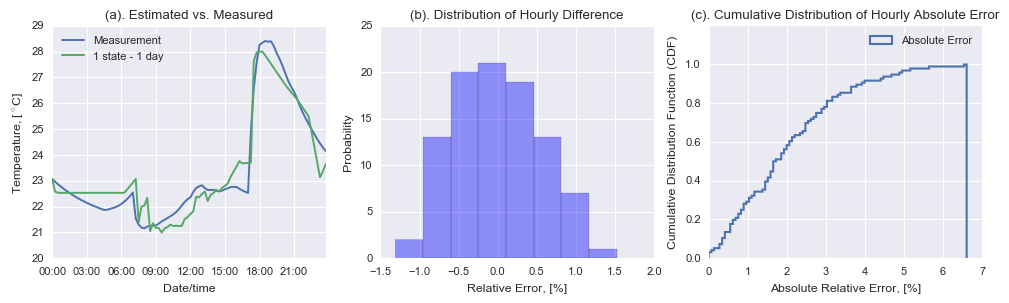

In [19]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,3, figsize=(12, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axes[0].plot(training_data.index[0:191], Tr[0:191], label='Measurement')
axes[0].plot(training_data.index[0:191], est_tr, label='1 state - 1 day')
sns.distplot((est_tr - Tr), kde=False, color="b", ax=axes[1])
axes[0].set_xlabel('Date/time')
axes[0].set_ylabel('Temperature, [$^\circ$C]')
axes[0].set_title('(a). Estimated vs. Measured')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))
axes[1].set_xlabel('Relative Error, [%]')
axes[1].set_ylabel('Probability')
axes[1].set_title('(b). Distribution of Hourly Difference')

axes[0].legend(loc='upper left')
# axes[1].legend()

axes[2].hist(abs(est_tr - Tr)/est_tr*100,bins=len(Tr),normed=1,histtype='step',lw=1.5,cumulative=1,label='Absolute Error')
axes[2].set_xlabel('Absolute Relative Error, [%]')
axes[2].set_ylabel('Cumulative Distribution Function (CDF)')
# axes[1].set_title('(b). Hourly Error between the Simulated and Measured')
axes[2].set_ylim(0, 1.2)
axes[2].set_title('(c). Cumulative Distribution of Hourly Absolute Error')
axes[2].legend()

fig.savefig('figures/validate-error.png', dpi=300, format='png',bbox_inches='tight')

## 2 states - 3 steps model

In [51]:
# Define the objective (to be minimize)
def rsme2(x, *args):
    Tr, mf, Ta, G, Ig, Ts, n = args
    total_err = 0
    Tr_hat = {}
    Tm_hat = {}
#     Tr_hat[0] = Tr[0]
#     Tm_hat[0] = Tr[0]
    M = len(Tr)
    for k in range(M-n):
        Tr_hat[k] = Tr[k]
        Tm_hat[k] = Tr[k]
        for j in range(n):
            Tm_hat[k+j+1] = x[5]*Tr_hat[k+j] + x[6]*Tm_hat[k+j]
            Tr_hat[k+j+1] =  x[0]*Tr_hat[k+j] + x[1]*Ts[k+j]*mf[k+j] + x[7]*Tm_hat[k+j] + (-x[1])*Tr_hat[k+j]*mf[k+j] + x[2]*Ta[k+j] + x[3]*G[k+j] + x[4]*Ig[k+j]
            total_err += (Tr_hat[k+j+1]-Tr[k+j+1])**2
    return sqrt(total_err/M)

def constraints(x, *args):
    Tr, mf, Ta, G, Ig, Ts, n = args
    Tr_hat = {}
    Tm_hat = {}
#     Tr_hat[0] = Tr[0]
#     Tm_hat[0] = Tr[0]
    cons = []
    M = len(Tr)
    for k in range(M-n):
        Tr_hat[k] = Tr[k]
        Tm_hat[k] = Tr[k]
        for j in range(n):
            Tm_hat[k+j+1] = x[5]*Tr_hat[k+j] + x[6]*Tm_hat[k+j]
            Tr_hat[k+j+1] =  x[0]*Tr_hat[k+j] + x[1]*Ts[k+j]*mf[k+j] + x[7]*Tm_hat[k+j] + (-x[1])*Tr_hat[k+j]*mf[k+j] + x[2]*Ta[k+j] + x[3]*G[k+j] + x[4]*Ig[k+j]
            cons.append(2.5*Tr_hat[k+j+1]-Tm_hat[k+j+1])
            cons.append(Tm_hat[k+j+1]-0.01*Tr_hat[k+j+1])
    return cons

# Define the lower and upper bounds for x, respectively
args = (Tr, mf, Ta, G, Ig, Ts, 30)

lb = [0, 0, 0, 0, 0, 0, 0, 0]
ub = [1, 1, 1, 1, 1, 1, 1, 1]

xopt, fopt = pso(rsme2, lb, ub, f_ieqcons=constraints, args=args, maxiter=10000)